<a href="https://colab.research.google.com/github/jmorala/TFMDS/blob/main/cuadernos/01_exploracion_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inicializar directorios
Clonar repositorio github
Posicionarse en el directorio raíz

In [1]:
# Este comando descarga el repositorio entero a una carpeta llamada 'TFMDS' en Colab.
#!git clone https://github.com/jmorala/TFMDS.git

In [2]:
import os

# Detectar si estamos en Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Configurar el directorio de trabajo según el entorno
if IN_COLAB:
    os.chdir('TFMDS')
else:
    # En VS Code local, nos movemos al directorio raíz del proyecto
    # Usa raw string para evitar errores de escape en rutas Windows
    current_dir = r'C:\Users\jmora\Documents\TFMDS'
    os.chdir(current_dir)

# OPCIONAL: Para verificar que estás en la ruta correcta y ver las carpetas
print("Directorio de trabajo actual:", os.getcwd())

Directorio de trabajo actual: C:\Users\jmora\Documents\TFMDS


# Compresión inicial y definición del problema
## Generación de los datos
Los datos han sido recibidos por el tutor de TFM

Se trata de un caso real de un punto de venta de una empresa de distribución de productos para el automóvil

La información que se proporciona en los ficheros es de 1000 productos anonimizados por motivos de confidencialidad

## Objetivo
El objetivo es generar modelos que prevean las ventas en un horizonte de tiempo (***pendiente definir este horizonte***), y elegir el que dé mejor resultado.

Para el desarrollo del modelo hay que valorar si conviene un modelo para todos los productos o uno para cada cluster de productos.

Una vez seleccionado el modelo con mejor precisión, se estimará el stock final necesario.

Después se comparará con un modelo Naive para ver qué modelo tiene mejor resultado

## Modelo de datos
Los datos recibidos están en una hoja de cálculo con varias pestañas, cada pestaña ha sido exportada a un fichero csv con separado de campos el caracter ';'.

Cada fichero contiene los siguientes datos:


* Ventas.csv: Histórico de ventas de los 1000 productos. Contiene los campos:
producto: código de producto (entero)
idSecuencia: fecha del día de venta (AAAAMMDD)
udsVenta: Unidades vendidas ese día (entero)
* Calendario.csv: Indica la fecha de festivo y fecha de apertura del punto de venta. Contiene los campos: idSecuencia: fecha del día de venta (AAAAMMDD) bolOpen: 1 si ese día la tienda estaba abierta 0 en el caso contrario. bolHoliday: 1 si ese día era festivo 0 en caso contrario.
* Promociones.csv: Contiene las fecha de inicio y fin de las campañas promocionales. Contiene llos campos: producto: código de producto. idSecuenciaIni: fecha inicial de promoción para el producto (AAAAMMDD). idSecuenciaFin: Último día de propomoción para el producto (AAAAMMDD)
* Stock.csv: No será una variable exógena para el modelo, pero sirve para identificar días con ventas cero por rotura de stock (stock=0), En estos casos, conviene, “reconstruir” las ventas para que los modelos no aprendan de estos periodos excepcionales de ventas a cero debido a roturas. Contiene los campos: producto: Código del producto. idSecuencia: día referente del stock (AAAAMMDD). udsStock: Unidades en el stock para ese día (entero).

***Incluir dibujo del modelo de datos***

# Evaluación de los datos y creación del dataset inicial

Para cada juego de datos comprobar:

*   Convertir los datos al tipo adecuado
*   No hay datos faltantes o nulos. En cuyo caso ver cómo actuar
*   En la serie temporal no faltan días
*   Los conjuntos de datos son coherentes en cuanto fechas y claves foráneas
*   Unir los datos en un único dataframe



## Archivo ventas.csv
acciones:
* Convertir los tipos de datos a los correctos
* Comprobar que no hay datos nulos
* Todos los productos tienen las mismas fechas informadas
* Están informados todos los días en el mismo rango de fechas para todos los artículos

In [3]:
import pandas as pd

# Ruta relativa del archivo CSV
RUTA_DATOS = 'datos/Ventas.csv'

# Cargar el archivo en un DataFrame de Pandas
dfventas = pd.read_csv(RUTA_DATOS, sep=';',
    parse_dates=['idSecuencia'],
    date_format='%Y%m%d')

# Muestra las primeras filas y la información de las columnas para iniciar la exploración
print("Primeras filas del DataFrame:")
print(dfventas.head())

print("\nInformación de las columnas y tipos de datos:")
dfventas.info()

Primeras filas del DataFrame:
   producto idSecuencia  udsVenta
0         1  2022-11-05        40
1         1  2022-11-06         0
2         1  2022-11-07        12
3         1  2022-11-08        28
4         1  2022-11-09        14

Información de las columnas y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654408 entries, 0 to 654407
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   producto     654408 non-null  int64         
 1   idSecuencia  654408 non-null  datetime64[ns]
 2   udsVenta     654408 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 15.0 MB


In [4]:
prod_vc = dfventas['producto'].value_counts()
print(prod_vc)
print(f'lecturas diferentes: {prod_vc.nunique()}')

producto
1       732
2       732
3       732
4       732
5       732
       ... 
996     732
997     732
998     732
999     732
1000    732
Name: count, Length: 894, dtype: int64
lecturas diferentes: 1


El número de productos es 894 y tienen 732 lecturas cada uno, no hay nulos en los datos

In [5]:
# Comprobar que todos los artículos tienen información de todos los días y coinciden en el rango de fechas

fecha_min = dfventas['idSecuencia'].min()
fecha_max = dfventas['idSecuencia'].max()
dias_esperados = (fecha_max - fecha_min).days + 1

resumen = dfventas.groupby('producto').agg({
    'idSecuencia': ['min', 'max', 'nunique']
})

validacion_ok = (
    (resumen[('idSecuencia', 'min')] == fecha_min).all() and
    (resumen[('idSecuencia', 'max')] == fecha_max).all() and
    (resumen[('idSecuencia', 'nunique')] == dias_esperados).all()
)

print(f"¿Datos completos y consistentes? {validacion_ok}")
print(f"Rango de fechas: {fecha_min} a {fecha_max}")
print(f"Número de días en cada artículo: {dias_esperados}")
print(resumen)



¿Datos completos y consistentes? True
Rango de fechas: 2022-11-05 00:00:00 a 2024-11-05 00:00:00
Número de días en cada artículo: 732
         idSecuencia                   
                 min        max nunique
producto                               
1         2022-11-05 2024-11-05     732
2         2022-11-05 2024-11-05     732
3         2022-11-05 2024-11-05     732
4         2022-11-05 2024-11-05     732
5         2022-11-05 2024-11-05     732
...              ...        ...     ...
996       2022-11-05 2024-11-05     732
997       2022-11-05 2024-11-05     732
998       2022-11-05 2024-11-05     732
999       2022-11-05 2024-11-05     732
1000      2022-11-05 2024-11-05     732

[894 rows x 3 columns]


Todos los productos tienen el mismo rango de fechas entre el 2022-11-05 hasta el 2024-11-05 y todos tienen todos los días informados

## Archivo Calendario.
acciones:
* Convertir los tipos de datos a los correctos
* Comprobar que no hay datos nulos
* Comprobar rango de fechas y que todos los días están informados
* El rango de fechas con las ventas debe coincidir, en caso contrario actualizar dataframes

In [6]:
# Ruta relativa del archivo CSV
RUTA_DATOS = 'datos/Calendario.csv'

# Cargar el archivo en un DataFrame de Pandas
dfcalendario = pd.read_csv(RUTA_DATOS, sep=';',
    parse_dates=['idSecuencia'],
    date_format='%Y%m%d')

# Muestra las primeras filas y la información de las columnas para iniciar la exploración
print("Primeras filas del DataFrame:")
print(dfcalendario.head())

print("\nInformación de las columnas y tipos de datos:")
dfcalendario.info()

Primeras filas del DataFrame:
  idSecuencia  bolOpen  bolHoliday
0  2025-02-05        1           0
1  2025-02-06        1           0
2  2023-12-23        1           0
3  2023-12-24        1           1
4  2024-09-02        1           0

Información de las columnas y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   idSecuencia  837 non-null    datetime64[ns]
 1   bolOpen      837 non-null    int64         
 2   bolHoliday   837 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 19.7 KB


Hay 837 días y no hay valores nulos

In [7]:
# Comprobar rango de fechas y que todos los días están informados

rango = dfcalendario['idSecuencia']
completo = (rango.max() - rango.min()).days + 1 == rango.nunique() == len(dfcalendario)
binario_ok = (
    dfcalendario['bolOpen'].isin([0, 1]).all() and
    dfcalendario['bolHoliday'].isin([0, 1]).all()
)

print(f"Calendario completo: {completo}")
print(f"Valores binarios OK: {binario_ok}")
print(f"Rango: {rango.min().date()} - {rango.max().date()} ({rango.nunique()} días)")
print(f"✅ TODO OK" if completo and binario_ok else "⚠️ HAY PROBLEMAS")

Calendario completo: True
Valores binarios OK: True
Rango: 2022-11-06 - 2025-02-19 (837 días)
✅ TODO OK


El rango de fechas va desde 2022-11-06 a 2025-02-19 y todos los días están informados y los datos de bolOpen y bolHoliday son correctos.

El rango de fechas no coincide con el de ventas (2022-11-05 - 2024-11-05), el día 2022-11-05 de ventas no tiene información de calendario, y a partir del día 2024-11-06 los datos de calendario no son relevantes al no tener información en ventas

Borrar fila de dfventas con fecha = fecha_min ya que no está en calendario y como los datos son anónimos no se puede saber la localización y calendario festivo local, cambiar el valor de fecha_min = fecha_mi n+ 1 para los posteriores tratamiento

In [8]:
# Borrar de dfventas la fila con idSecuencia = fecha_min ya que no está en calendario, y actualizar fecha_min
dfventas = dfventas[dfventas['idSecuencia'] != fecha_min]
# Añadir un día a fecha_min ya que se utiliza posteriormente
fecha_min += pd.Timedelta(days=1)
# Borrar filas de dfcalendario fuera del rango de fechas de dfventas
dfcalendario = dfcalendario[
    (dfcalendario['idSecuencia'] >= fecha_min) &
    (dfcalendario['idSecuencia'] <= fecha_max)
]

## Archivo Promociones.csv
Acciones:
* Comprobar que no hay nulos
* Todos los producto están en ventas
* Eliminar rangos de fechas que no están en ventas
* Adecuar los rangos de fechas que se solapan a las fechas de ventas


In [9]:
# Ruta relativa del archivo CSV
RUTA_DATOS = 'datos/Promociones.csv'

# Cargar el archivo en un DataFrame de Pandas
dfpromociones = pd.read_csv(RUTA_DATOS, sep=';',
    parse_dates=['idSecuenciaIni', 'idSecuenciaFin'],
    date_format='%Y%m%d')

# Muestra las primeras filas y la información de las columnas para iniciar la exploración
print("Primeras filas del DataFrame:")
print(dfpromociones.head())

print("\nInformación de las columnas y tipos de datos:")
dfpromociones.info()

Primeras filas del DataFrame:
   producto idSecuenciaIni idSecuenciaFin
0       469     2012-09-27     2012-11-21
1       554     2015-10-09     2015-11-17
2       972     2013-01-12     2013-03-11
3       117     2022-08-11     2022-09-07
4       399     2021-05-06     2021-06-06

Información de las columnas y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24718 entries, 0 to 24717
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   producto        24718 non-null  int64         
 1   idSecuenciaIni  24718 non-null  datetime64[ns]
 2   idSecuenciaFin  24718 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 579.5 KB


Hay 24.718 promociones y no hay valores nulos

In [10]:
# Verificar productos que no existen en dfventas
productos_invalidos = ~dfpromociones['producto'].isin(dfventas['producto'])
filas_productos_invalidos = dfpromociones[productos_invalidos]

# Verificar fechas fuera de rango
fechas_fuera_rango = (
    (dfpromociones['idSecuenciaIni'] < fecha_min) |
    (dfpromociones['idSecuenciaFin'] > fecha_max)
)
filas_fechas_invalidas = dfpromociones[fechas_fuera_rango]

# Mostrar resultados
print(f"Productos no existentes en dfventas: {productos_invalidos.sum()}")
if productos_invalidos.sum() > 0:
    print(filas_productos_invalidos)

print(f"\nFechas fuera de rango [{fecha_min.date()} - {fecha_max.date()}]: {fechas_fuera_rango.sum()}")
if fechas_fuera_rango.sum() > 0:
    print(filas_fechas_invalidas)

# Resumen
print(f"\n{'='*50}")
print(f"Total filas con problemas: {(productos_invalidos | fechas_fuera_rango).sum()}")

Productos no existentes en dfventas: 0

Fechas fuera de rango [2022-11-06 - 2024-11-05]: 21867
       producto idSecuenciaIni idSecuenciaFin
0           469     2012-09-27     2012-11-21
1           554     2015-10-09     2015-11-17
2           972     2013-01-12     2013-03-11
3           117     2022-08-11     2022-09-07
4           399     2021-05-06     2021-06-06
...         ...            ...            ...
24713       502     2013-01-12     2013-03-11
24714       423     2022-07-14     2022-08-10
24715        24     2017-01-10     2017-03-06
24716       647     2017-10-05     2017-11-05
24717       879     2019-03-29     2019-04-25

[21867 rows x 3 columns]

Total filas con problemas: 21867


Todos los productos en Promociones están en Ventas.

Hay muchas promociones que no pertenecen al rango de los datos de Ventas, se borran los datos en que idSecunciaFin es menor que fecha_min, idSecuenciaIni es mayor que fecha_max y los rangos que se solapan se fija IdSecuenciaIni o IdSecuenciaFin a fecha_min o fecha_nax

In [11]:
# Filtrar y ajustar promociones según el rango de ventas

# 1. Eliminar promociones completamente fuera de rango
# - Promociones que terminan antes de fecha_min
# - Promociones que empiezan después de fecha_max
dfpromociones = dfpromociones[
    ~((dfpromociones['idSecuenciaFin'] < fecha_min) |
      (dfpromociones['idSecuenciaIni'] > fecha_max))
].copy()

print(f"Filas después de eliminar promociones fuera de rango: {len(dfpromociones)}")

# 2. Ajustar fechas de promociones que se solapan con los límites
# Si idSecuenciaIni < fecha_min, ajustar a fecha_min
dfpromociones.loc[dfpromociones['idSecuenciaIni'] < fecha_min, 'idSecuenciaIni'] = fecha_min

# Si idSecuenciaFin > fecha_max, ajustar a fecha_max
dfpromociones.loc[dfpromociones['idSecuenciaFin'] > fecha_max, 'idSecuenciaFin'] = fecha_max

print(f"Fechas ajustadas al rango: [{fecha_min.date()} - {fecha_max.date()}]")

# 3. Verificación final
print(f"\nVerificación:")
print(f"- Todas las fechas ini >= fecha_min: {(dfpromociones['idSecuenciaIni'] >= fecha_min).all()}")
print(f"- Todas las fechas fin <= fecha_max: {(dfpromociones['idSecuenciaFin'] <= fecha_max).all()}")
print(f"- Total promociones válidas: {len(dfpromociones)}")

Filas después de eliminar promociones fuera de rango: 3096
Fechas ajustadas al rango: [2022-11-06 - 2024-11-05]

Verificación:
- Todas las fechas ini >= fecha_min: True
- Todas las fechas fin <= fecha_max: True
- Total promociones válidas: 3096


## Archivo Stock.csv
Acciones:
* Comprobar que no hay nulos
* Comprobar que todos los productos están en ventas, y que todos los productos de ventas están en stock
* Comprobar que las fechas-producto de ventas están en stock

In [12]:
# Ruta relativa del archivo CSV
RUTA_DATOS = 'datos/Stock.csv'

# Cargar el archivo en un DataFrame de Pandas
dfstock = pd.read_csv(RUTA_DATOS, sep=';',
    parse_dates=['idSecuencia'],
    date_format='%Y%m%d')

# Muestra las primeras filas y la información de las columnas para iniciar la exploración
print("Primeras filas del DataFrame:")
print(dfstock.head())

print("\nInformación de las columnas y tipos de datos:")
dfstock.info()

Primeras filas del DataFrame:
   producto idSecuencia  udsStock
0       240  2024-01-03        71
1       240  2024-01-04        71
2       240  2024-01-05        71
3       240  2024-01-06        68
4       240  2024-01-07        68

Información de las columnas y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654408 entries, 0 to 654407
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   producto     654408 non-null  int64         
 1   idSecuencia  654408 non-null  datetime64[ns]
 2   udsStock     654408 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 15.0 MB


No hay valores nulos y tiene 654.408 datos

Comprobar que:
* Todos los productos de Stock están en Ventas
* Todos los producto de ventas están en Stock
* Todas las filas de Ventas con producto-Fecha (producto - idSecuencia) están en Stock

In [13]:
# Comprobaciones entre dfventas y dfstock

# 1) Productos: stock \ ventas y ventas \ stock
prod_stock = set(dfstock['producto'].unique())
prod_ventas = set(dfventas['producto'].unique())

prod_only_in_stock = sorted(prod_stock - prod_ventas)
prod_only_in_ventas = sorted(prod_ventas - prod_stock)

print(f"Productos en Stock pero NO en Ventas: {len(prod_only_in_stock)}")
if prod_only_in_stock:
    print("Ejemplos:", prod_only_in_stock[:10])

print(f"Productos en Ventas pero NO en Stock: {len(prod_only_in_ventas)}")
if prod_only_in_ventas:
    print("Ejemplos:", prod_only_in_ventas[:10])

# 2) Comprobar que todas las filas de Ventas (producto, idSecuencia) están en Stock
# Usamos merge con indicador para detectar filas de dfventas que no tienen match en dfstock
merge_pairs = dfventas.merge(
    dfstock[['producto', 'idSecuencia']],
    on=['producto', 'idSecuencia'],
    how='left',
    indicator=True
)

missing_pairs = merge_pairs[merge_pairs['_merge'] == 'left_only']
n_missing_pairs = len(missing_pairs)

print(f"\nFilas de Ventas sin correspondencia en Stock (producto, fecha): {n_missing_pairs} / {len(dfventas)}")
if n_missing_pairs:
    print("Primeras filas de ejemplo (Ventas sin Stock):")
    display(missing_pairs.head(10)[['producto', 'idSecuencia', 'udsVenta']])

Productos en Stock pero NO en Ventas: 0
Productos en Ventas pero NO en Stock: 0

Filas de Ventas sin correspondencia en Stock (producto, fecha): 0 / 653514


## Unir datos en un único dataframe

In [14]:
# Resultado: df_final con columnas: idSecuencia, producto, udsVenta, bolPromocion, bolOpen, bolHoliday
from collections import defaultdict

# Construir un diccionario producto -> lista de intervalos (inicio, fin)
promotions_dict = defaultdict(list)
for row in dfpromociones[['producto', 'idSecuenciaIni', 'idSecuenciaFin']].itertuples(index=False):
    prod, inicio, fin = row
    promotions_dict[prod].append((inicio, fin))

# Merge con calendario para obtener bolOpen y bolHoliday
df_merged = dfventas.merge(
    dfcalendario[['idSecuencia', 'bolOpen', 'bolHoliday']],
    on='idSecuencia',
    how='left'
)

# Función que determina si en una fecha dada hay promoción para ese producto
def _has_promo(prod, fecha):
    intervals = promotions_dict.get(prod)
    if not intervals:
        return 0
    for inicio, fin in intervals:
        if inicio <= fecha <= fin:
            return 1
    return 0

# Aplicar la función por filas
df_merged['bolPromocion'] = df_merged.apply(lambda r: _has_promo(r['producto'], r['idSecuencia']), axis=1).astype(int)

# Incorporar a df_merged el valor de udsStock, en que producto y idSecuencia coincidan
df_merged = df_merged.merge(
    dfstock[['producto', 'idSecuencia', 'udsStock']],
    on=['producto', 'idSecuencia'],
    how='left'
)

# Seleccionar y reordenar columnas finales
cols = ['idSecuencia', 'producto', 'udsVenta', 'bolPromocion', 'bolOpen', 'bolHoliday', 'udsStock']
existing_cols = [c for c in cols if c in df_merged.columns]
df_final = df_merged[existing_cols].copy()

# Verificaciones rápidas
print('df_final shape:', df_final.shape)
print('\nValores únicos en bolPromocion:', df_final['bolPromocion'].unique())
print('Filas con promoción (bolPromocion==1):', int(df_final['bolPromocion'].sum()))
print('Filas sin promoción (bolPromocion==0):', len(df_final) - int(df_final['bolPromocion'].sum()))
print('\nValores únicos en bolOpen:', df_final['bolOpen'].unique())
print('Valores con bolOpen == 1:', int(df_final['bolOpen'].sum()))
print('Valores con bolOpen == 0:', len(df_final) - int(df_final['bolOpen'].sum()))
print('\nValores únicos en bolHoliday:', df_final['bolHoliday'].unique())
print('Valores con bolHoliday == 1:', int(df_final['bolHoliday'].sum()))
print('Valores con bolHoliday == 0:', len(df_final) - int(df_final['bolHoliday'].sum()))
print('\nExisten valores nulos en df_final?:', df_final.isnull().any().any())

# Para cada producto contar cuantas filas tiene
prod_vc = df_final['producto'].value_counts()
print("\nNúmero de filas por producto:")
print(prod_vc)
print(f'lecturas diferentes: {prod_vc.nunique()}')

df_final.head()

df_final shape: (653514, 7)

Valores únicos en bolPromocion: [1 0]
Filas con promoción (bolPromocion==1): 85465
Filas sin promoción (bolPromocion==0): 568049

Valores únicos en bolOpen: [0 1]
Valores con bolOpen == 1: 544446
Valores con bolOpen == 0: 109068

Valores únicos en bolHoliday: [1 0]
Valores con bolHoliday == 1: 121584
Valores con bolHoliday == 0: 531930

Existen valores nulos en df_final?: False

Número de filas por producto:
producto
1       731
2       731
3       731
4       731
5       731
       ... 
996     731
997     731
998     731
999     731
1000    731
Name: count, Length: 894, dtype: int64
lecturas diferentes: 1


,idSecuencia,producto,udsVenta,bolPromocion,bolOpen,bolHoliday,udsStock
0,2022-11-06,1,0,1,0,1,148
1,2022-11-07,1,12,1,1,0,148
2,2022-11-08,1,28,1,1,0,136
3,2022-11-09,1,14,1,1,0,306
4,2022-11-10,1,26,1,1,0,291


## Reconstruir ventas cuando stock 0
En el caso en que un producto-día el stock es cero, entonces las ventas serán 0, no porque no haya demanda si no porque no hay unidades disponibles para la venta. En este caso hay que reconstruir las ventas que se tendrían para es producto-día.

***El caso de ventas = stock = 0 y bolOpen=0 no se considera rotura de stock, ya que la tienda no está abierta***


Inicialmente se comprueba las estadísticas de rotura de stock:
* Número de roturas y porcentaje sobre el total
* Productos afectados, cuantos días tuvieron rotura
* Meses con roturas

In [15]:
# ============================================================================
# 1. ANÁLISIS DE ROTURAS DE STOCK
# ============================================================================

print("=" * 80)
print("ANÁLISIS DE ROTURAS DE STOCK Y VENTAS CERO")
print("=" * 80)

# Identificar casos de ventas cero con stock cero
df_final['rotura_stock'] = (df_final['udsVenta'] == 0) & (df_final['udsStock'] == 0) & (df_final['bolOpen'] == 1)

# Estadísticas generales
total_registros = len(df_final)
roturas = df_final['rotura_stock'].sum()
porcentaje_roturas = (roturas / total_registros) * 100

print(f"\n📊 ESTADÍSTICAS GENERALES:")
print(f"   Total registros: {total_registros:,}")
print(f"   Roturas de stock (ventas=0, stock=0, bolOpen==1): {roturas:,}")
print(f"   Porcentaje de roturas: {porcentaje_roturas:.2f}%")

# Análisis por producto
productos_afectados = df_final[df_final['rotura_stock']]['producto'].nunique()
total_productos = df_final['producto'].nunique()
print(f"\n   Productos afectados por roturas: {productos_afectados} de {total_productos}")

# Días con roturas por producto
roturas_por_producto = df_final[df_final['rotura_stock']].groupby('producto').size()
print(f"\n📈 DISTRIBUCIÓN DE ROTURAS POR PRODUCTO:")
print(f"   Media de días con rotura: {roturas_por_producto.mean():.1f}")
print(f"   Mediana: {roturas_por_producto.median():.1f}")
print(f"   Máximo días con rotura: {roturas_por_producto.max()}")
print(f"   Mínimo días con rotura: {roturas_por_producto.min()}")

# Top 10 productos con más roturas
print(f"\n🔝 TOP 10 PRODUCTOS CON MÁS DÍAS DE ROTURA:")
top_roturas = roturas_por_producto.nlargest(10)
for i, (producto, dias) in enumerate(top_roturas.items(), 1):
    print(f"   {i:2d}. Producto {producto}: {dias} días")

# Análisis temporal: roturas por año-mes
df_final['anio_mes'] = df_final['idSecuencia'].dt.to_period('M')
roturas_por_mes = df_final[df_final['rotura_stock']].groupby('anio_mes').agg({
    'rotura_stock': 'sum',
    'producto': 'nunique'
}).rename(columns={'rotura_stock': 'num_roturas', 'producto': 'productos_afectados'})

# Calcular porcentaje sobre total de registros por mes
total_por_mes = df_final.groupby('anio_mes').size()
roturas_por_mes['total_registros'] = total_por_mes
roturas_por_mes['pct_roturas'] = (roturas_por_mes['num_roturas'] / roturas_por_mes['total_registros'] * 100).round(2)

print(f"\n📅 ROTURAS DE STOCK POR AÑO-MES:")
print("-" * 90)
print(f"{'Año-Mes':<12} {'Roturas':>10} {'Productos':>12} {'Total Reg.':>12} {'% Roturas':>10}")
print("-" * 90)
for periodo, row in roturas_por_mes.iterrows():
    print(f"{str(periodo):<12} {row['num_roturas']:>10,.0f} {row['productos_afectados']:>12} "
          f"{row['total_registros']:>12,.0f} {row['pct_roturas']:>9.2f}%")

# Identificar meses con más problemas
print(f"\n🔴 MESES CON MÁS ROTURAS:")
top_meses = roturas_por_mes.nlargest(5, 'num_roturas')
for i, (periodo, row) in enumerate(top_meses.iterrows(), 1):
    print(f"   {i}. {periodo}: {row['num_roturas']:,.0f} roturas ({row['pct_roturas']:.2f}%)")

print(f"\n📈 TENDENCIA TEMPORAL:")
print(f"   Media de roturas por mes: {roturas_por_mes['num_roturas'].mean():,.1f}")
print(f"   Mediana de roturas por mes: {roturas_por_mes['num_roturas'].median():,.1f}")

ANÁLISIS DE ROTURAS DE STOCK Y VENTAS CERO

📊 ESTADÍSTICAS GENERALES:
   Total registros: 653,514
   Roturas de stock (ventas=0, stock=0, bolOpen==1): 21,383
   Porcentaje de roturas: 3.27%

   Productos afectados por roturas: 894 de 894

📈 DISTRIBUCIÓN DE ROTURAS POR PRODUCTO:
   Media de días con rotura: 23.9
   Mediana: 3.0
   Máximo días con rotura: 426
   Mínimo días con rotura: 1

🔝 TOP 10 PRODUCTOS CON MÁS DÍAS DE ROTURA:
    1. Producto 766: 426 días
    2. Producto 709: 407 días
    3. Producto 389: 405 días
    4. Producto 731: 404 días
    5. Producto 129: 402 días
    6. Producto 767: 396 días
    7. Producto 44: 395 días
    8. Producto 215: 395 días
    9. Producto 720: 378 días
   10. Producto 270: 360 días

📅 ROTURAS DE STOCK POR AÑO-MES:
------------------------------------------------------------------------------------------
Año-Mes         Roturas    Productos   Total Reg.  % Roturas
-----------------------------------------------------------------------------------

Graficar las roturas de stock y el número de artículos con rotura en la linea del tiempo

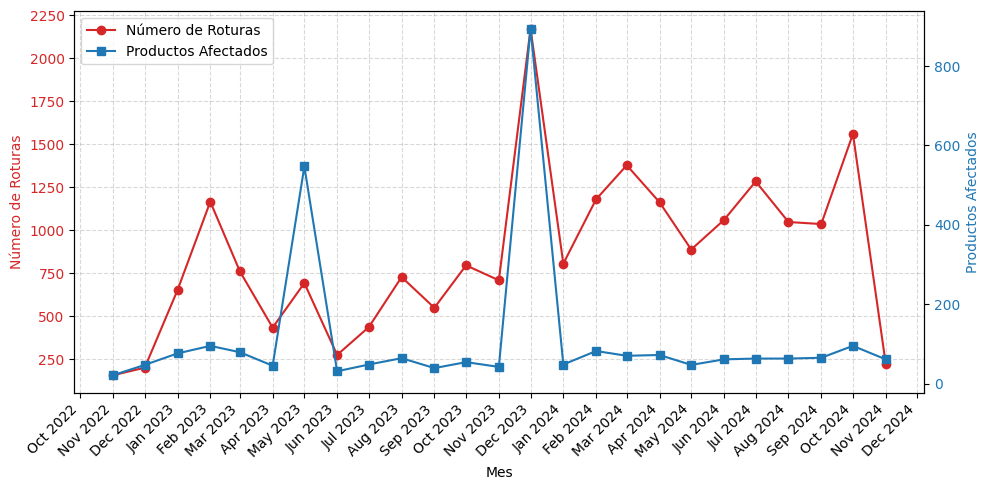

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# gráfico de roturas por mes y cuantía de productos afectados
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

x = roturas_por_mes.index.to_timestamp()
ax1.plot(x, roturas_por_mes['num_roturas'], color='tab:red', marker='o', label='Número de Roturas')
ax2.plot(x, roturas_por_mes['productos_afectados'], color='tab:blue', marker='s', label='Productos Afectados')

# fondo blanco pero mostrar líneas de fondo (grid)
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax1.grid(True, which='major', linestyle='--', color='gray', alpha=0.3)

# etiquetas y colores
ax1.set_xlabel('Mes')
ax1.set_ylabel('Número de Roturas', color='tab:red')
ax2.set_ylabel('Productos Afectados', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# ticks mensuales y formato legible
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# leyenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

fig.tight_layout()
plt.show()


Recontruir los valores cero de ventas cuando el stock es cero

Métodos posibles de elegir el valor para un producto-día:
* Media/Mediana/Moda de los valores
* Utilizar un modelo de regresión lineal o también imputación iterativa, utilizando cobariables
* La media de los N días anteriores y posteriores sin rotura
* La media del mismo día de la semana sin rotura
* kNN-imputation, utilizando los k registros vecinos más próximos según distancia

Los valores de referencia para el cáclculo, no incluyen los mismos que se están reconstruyendo (udsventa=udsStock=0) ni los que pertenecen a días cerrados (bolOpen=0)

Se opta por la media de N días anteriores y posteriores ya que utiliza los datos más cercanos al día de rotura y así captura la tendencia temporal 

In [17]:
def recons_stock_media_N_dias(df, n_registros=7):
    """
    Reconstruye ventas usando la media de N registros anteriores y posteriores sin rotura
    
    Args:
        df: DataFrame con las columnas necesarias
        n_registros: Número de registros anteriores y posteriores a considerar
    """
    df_recons = df.copy()
    
    for idx in df[(df['rotura_stock']) & (df['bolOpen'] == 1)].index:
        producto = df.loc[idx, 'producto']
        fecha = df.loc[idx, 'idSecuencia']
        
        # Filtrar solo el producto actual y ordenar por fecha
        df_prod = df[
            (df['producto'] == producto) & 
            (~df['rotura_stock']) & 
            (df['bolOpen'] == 1)
        ].sort_values('idSecuencia').reset_index(drop=True)  # IMPORTANTE: ordenar y resetear índice
        
        # Buscar la posición de la fecha más cercana inferior a 'fecha'
        fechas_anteriores = df_prod['idSecuencia'] < fecha
        
        if fechas_anteriores.any():
            # La última fecha anterior a 'fecha' será la posición más cercana
            pos_actual = fechas_anteriores[::-1].idxmax()  
                        
            # Obtener índices de los n registros anteriores y posteriores
            start_pos = max(0, pos_actual - n_registros + 1)
            end_pos = min(len(df_prod), pos_actual + n_registros + 1)
            
            # Obtener registros cercanos por posición
            df_cercanos = df_prod.iloc[start_pos:end_pos]
            
            if len(df_cercanos) > 0:
                df_recons.loc[idx, 'udsVenta'] = int(round(df_cercanos['udsVenta'].mean()))
        else:
            # Si no hay fechas anteriores, usar los primeros n_registros
            df_cercanos = df_prod.head(n_registros)
            if len(df_cercanos) > 0:
                df_recons.loc[idx, 'udsVenta'] = int(round(df_cercanos['udsVenta'].mean()))
    
    return df_recons

# Aplicar la reconstrucción
df_final = recons_stock_media_N_dias(df=df_final, n_registros=7)


In [21]:
df_final.head()

,idSecuencia,producto,udsVenta,bolPromocion,bolOpen,bolHoliday,udsStock,rotura_stock,anio_mes
0,2022-11-06,1,0,1,0,1,148,False,2022-11
1,2022-11-07,1,12,1,1,0,148,False,2022-11
2,2022-11-08,1,28,1,1,0,136,False,2022-11
3,2022-11-09,1,14,1,1,0,306,False,2022-11
4,2022-11-10,1,26,1,1,0,291,False,2022-11


## Tratar caso de día cerrado y hay ventas


In [30]:
# Mostrar df_final en que la tienda está cerrada y udsVenta es mayor que
print("\n" + "="*70)
print("ANÁLISIS: ventas en días con la tienda cerrada (bolOpen == 0)")
print("="*70)

mask = (df_final['bolOpen'] == 0) & (df_final['udsVenta'] > 0)
cols_to_show = ['idSecuencia', 'producto', 'udsVenta', 'bolOpen']

casos_encontrados = mask.sum()
porcentaje = (casos_encontrados / len(df_final) * 100) if len(df_final) > 0 else 0

print(f"\n📊 Registros: {casos_encontrados:,} de {len(df_final):,} ({porcentaje:.2f}%)")

if casos_encontrados > 0:
    resultado = df_final[mask][cols_to_show]
    print(f"🔍 Total unidades vendidas en día festivo: {resultado['udsVenta'].sum():,}")
    print(f"🏷️  Productos afectados: {resultado['producto'].nunique()}")
    print(f"\n{resultado.head()}")
else:
    print("✓ No se detectaron inconsistencias.")

print("="*70)


ANÁLISIS: ventas en días con la tienda cerrada (bolOpen == 0)

📊 Registros: 7,128 de 653,514 (1.09%)
🔍 Total unidades vendidas en día festivo: 25,397
🏷️  Productos afectados: 834

     idSecuencia  producto  udsVenta  bolOpen
35    2022-12-11         1         2        0
385   2023-11-26         1         5        0
942   2023-06-05         2        12        0
946   2023-06-09         2        19        0
1037  2023-09-08         2         9        0


Determinar qué hacer con los días cerrados y que tienen ventas

In [19]:
# guardar el DataFrame final reconstruido a un nuevo CSV
RUTA_SALIDA = 'datos/STDatosVentasTienda.csv'
df_final.to_csv(RUTA_SALIDA, sep=';', index=False)
print("=" * 80)
print("GUARDADO EL DATAFRAME FINAL RECONSTRUIDO EN:", RUTA_SALIDA)

GUARDADO EL DATAFRAME FINAL RECONSTRUIDO EN: datos/STDatosVentasTienda.csv
